In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os.path
from pathlib import Path
import time
import pandas as pd
import pickle as pkl
import librosa as lb
from sklearn import metrics

In [2]:
hop_sec = 512 * 1 / 22050
n_cores = 8
downsample = 1

In [3]:
ANNOTATIONS_ROOT_CLEAN = Path('/home/cchang/ttmp/raw_data/Chopin_Mazurkas/annotations_beat')
FEATURES_ROOT_CLEAN = Path('/home/cchang/ttmp/features/clean')

In [25]:
times = np.array([5, 10, 15, 20, 25, 30])
# times = [15]
#folder_names = ['dtw1', 'dtw2', 'dtw3', 'dtw4', 'subseqdtw', 'nwtw/gamma_0.346']
# folder_names = ['nwtw/gamma_0.8']

cfg_options = ['toy', 'small', 'small2', 'medium', 'train_benchmark', 'test_benchmark']
cfg = cfg_options[2] # Change this to appropriate benchmark

if cfg == 'toy':
    query_list = 'cfg_files/query.train_toy.list'
elif cfg == 'small':
    query_list = 'cfg_files/query.train_small.list'
elif cfg == 'small2':
    query_list = 'cfg_files/query.train_small2.list'
elif cfg == 'medium':
    query_list = 'cfg_files/query.train_medium.list'
elif cfg == 'train_benchmark':
    query_list = 'cfg_files/query.train.list'
elif cfg == 'test_benchmark':
    query_list = 'cfg_files/query.test.list'

## Attribution

### Functions

In [26]:
def eval_attribution(hypdir, index, query_list, hop_sec, annot_file, \
                     savefile = None, scoring_collar = 0.1, sr = 22050, planeAttrib=True):
    '''
    Evaluate the attribution task
    '''
    
    df = pd.read_csv(annot_file)
    allTimestamps = df.set_index('name').to_dict(orient='index')
    attributions = []
    
    # ************************************************************************************************************
    # This section should be easily parallelizable with a starmap
    # Just turn the inputs to evalQuery into a list, 
    #     starmap evalQuery, and store the results in a list called attributions
    files = []
    with open(query_list, 'r') as f:
        for line in f:
            files.append(line)
    print(files[index])
    theseAttributions = evalQuery_attrib(files[index], allTimestamps, hypdir, hop_sec, annot_file, scoring_collar, sr, planeAttrib)
    if len(theseAttributions) > 0:
        attributions.append(theseAttributions)
    #return np.vstack(attributions)
    #return evalQuery_attrib(line, allTimestamps, hypdir, hop_sec, annot_file, scoring_collar, sr)
    # ************************************************************************************************************
    
    return np.vstack(attributions)
    
#     if savefile is not None:
#         if planeAttrib:
#             outdir = os.path.dirname(savefile)
#             outdir = Path(outdir)
#             outdir.mkdir(parents=True, exist_ok=True)
#             pkl.dump(attributions, open(savefile, 'wb'))
#             return attributions
#         else:
#             ROC = calc_ROC(attributions)
#             #return attributions
#             if savefile is not None:
#                 outdir = os.path.dirname(savefile)
#                 outdir = Path(outdir)
#                 outdir.mkdir(parents=True, exist_ok=True)
#                 pkl.dump(ROC, open(savefile, 'wb'))

#             return ROC

In [13]:
def evalQuery_attrib(line, allTimestamps, hypdir, hop_sec, annot_file, scoring_collar, sr, planeAttrib):
    scoring_collar_frames = int(scoring_collar / hop_sec)

    parts = line.strip().split()
    assert len(parts) == 2
    basename = os.path.basename(parts[0]) + '__' + os.path.basename(parts[1])
    hypfile = hypdir + '/' + basename + '.pkl'

    if not os.path.exists(hypfile):
        print(hypfile)
        print("X", end='')
        return np.array([])

    hypalign = pkl.load(open(hypfile, 'rb'))
    if hypalign is not None:
        path = hypalign['wp']

        times = allTimestamps[os.path.basename(parts[0]) + ".wav"]

        firstRepEndTime = times['beginning replacement end (idx)'] / sr
        midRepStartTime = times['middle replacement start (idx)'] / sr
        midRepEndTime = times['middle replacement end (idx)'] / sr
        lastRepStartTime = times['ending replacement start (idx)'] / sr
        boundaries = np.array([firstRepEndTime, midRepStartTime, midRepEndTime, lastRepStartTime])

        gt = getAttributionGT(path, boundaries, scoring_collar, hop_sec)
    
        # Impute cost scores or plane attributions
        if planeAttrib:
            preds = np.interp(np.arange(path[-1,0]), path[:,0], path[:,2])
            preds = np.ceil(preds) # If frame is in both planes, default to visible (match)
        # Interpolate here to fill in the frames that the path jumps over
        else:
            preds = np.interp(np.arange(path[-1,0]), path[:,0], hypalign["costs"])

        attributions = np.hstack((gt.reshape((-1,1)), preds.reshape((-1,1))))
        
        collarFilter = gt >= 0
        attributions = attributions[collarFilter, :]
        return attributions
    else:
#         print("X", end='')
        return np.array([])

In [14]:
def getAttributionGT(path, boundaries, scoring_collar, hop_sec):
    query_length = path[-1,0]
    boundaryFrames = np.round(boundaries / hop_sec).astype(int)
    # Assemble gt with no scoring collar
    gt = np.zeros(query_length) + 1
    gt[boundaryFrames[0]:boundaryFrames[1]] = 0
    gt[boundaryFrames[2]:boundaryFrames[3]] = 0
    
    # Apply scoring collar:
    for boundary in boundaries:
        collarStartTime = boundary - scoring_collar
        collarStartFrame = int(np.ceil(collarStartTime / hop_sec))
        collarEndTime = boundary + scoring_collar
        collarEndFrame = int(np.ceil(collarEndTime / hop_sec))
        gt[collarStartFrame:collarEndFrame] = -1
    
    return gt

In [15]:
def calc_ROC(attributions):
    fps, tps, thresholds = metrics.roc_curve(attributions[:,0], attributions[:,1])
    return np.array([thresholds, fps, 1-tps]).T

In [16]:
def planeAttribToFPFN(paFile):
    attribs = pkl.load(open(paFile, 'rb'))
    diffs = attribs[:,1] - attribs[:,0] # 0 for correct, 1 for fp, -1 for fn
    fp = np.sum(diffs == 1) / (np.sum(attribs[:,0] == 0)) # num fp / num true neg
    fn = np.sum(diffs == -1) / (np.sum(attribs[:,0] == 1)) # num fn / num true pos
    return fp, fn

### Evaluate Attribution

In [52]:
# folder_names = ['dtw233', 'dtw111', 'nwtw/gamma_0.8']
folder_names = ['hstw/gamma_10_beta_%s' %b for b in [0,1,2,5,10,20,50,100,125,150,200]]

t = 5
index = -2
folder = 0


EXPERIMENTS_ROOT = '/home/cchang/ttmp/partial_match/%s/experiments/align_clean_to_%ss' % (cfg, t)
# EVALUATIONS_ROOT = '/home/cchang/ttmp/partial_match/%s/evaluations/attribution/align_clean_to_%ss' % (cfg, t)

ts = '/home/cchang/ttmp/raw_data/partial_match/Chopin_Mazurkas_partial_match_%ss/replacement_ts.csv' % t

allAttrib = []
#     savefile = EVALUATIONS_ROOT + "/" + savefile_names[i]
hypdir = EXPERIMENTS_ROOT + "/" + folder_names[folder]
print(hypdir)

start = time.time()
for index in range(100):
    attrib = eval_attribution(hypdir, index, query_list, hop_sec, ts, savefile = None, scoring_collar = 0.1, planeAttrib=True)
    allAttrib.append(attrib)

print('Took ', time.time() - start)

/home/cchang/ttmp/partial_match/small2/experiments/align_clean_to_5s/hstw/gamma_10_beta_0
Chopin_Op030No2/Chopin_Op030No2_Ashkenazy-1982_pid50848-03 Chopin_Op030No2/Chopin_Op030No2_Biret-1990_pid9062-19

Chopin_Op030No2/Chopin_Op030No2_Fou-1978_pid9071-30 Chopin_Op030No2/Chopin_Op030No2_Francois-1956_pid9070b-02

Chopin_Op030No2/Chopin_Op030No2_Biret-1990_pid9062-19 Chopin_Op030No2/Chopin_Op030No2_Poblocka-1999_pid9093-19

Chopin_Op030No2/Chopin_Op030No2_Chiu-1999_pid9048-19 Chopin_Op030No2/Chopin_Op030No2_Milkina-1970_pid9099-19

Chopin_Op030No2/Chopin_Op030No2_Brailowsky-1960_pid9060-19 Chopin_Op030No2/Chopin_Op030No2_Cortot-1951_pid9066-19

Chopin_Op017No4/Chopin_Op017No4_Horowitz-1985_pid50534-05 Chopin_Op017No4/Chopin_Op017No4_Rubinstein-1939_pid9049-13

Chopin_Op017No4/Chopin_Op017No4_Blet-2003_pid9103-07 Chopin_Op017No4/Chopin_Op017No4_Czerny-Stefanska-1949_pid9085-15

Chopin_Op030No2/Chopin_Op030No2_Chiu-1999_pid9048-19 Chopin_Op030No2/Chopin_Op030No2_Francois-1956_pid9070b-02


Chopin_Op017No4/Chopin_Op017No4_Blet-2003_pid9103-07 Chopin_Op017No4/Chopin_Op017No4_Rummel-1943_pid54851-12

Chopin_Op017No4/Chopin_Op017No4_Luisada-1990_pid9055-13 Chopin_Op017No4/Chopin_Op017No4_Magaloff-1977_pid9074f-13

Chopin_Op017No4/Chopin_Op017No4_Lushtak-2004_pid9088-08 Chopin_Op017No4/Chopin_Op017No4_Perahia-1994_pid54293-09

Chopin_Op017No4/Chopin_Op017No4_Kiepura-1999_pid9098-20 Chopin_Op017No4/Chopin_Op017No4_Smith-1975_pid9054-13

Chopin_Op017No4/Chopin_Op017No4_Falvay-1989_pid9068-08 Chopin_Op017No4/Chopin_Op017No4_Olejniczac-1990_pid9100b-17

Chopin_Op017No4/Chopin_Op017No4_Lushtak-2004_pid9088-08 Chopin_Op017No4/Chopin_Op017No4_Smith-1975_pid9054-13

Chopin_Op017No4/Chopin_Op017No4_Levy-1951_pid915406-13 Chopin_Op017No4/Chopin_Op017No4_Ohlsson-1999_pid9153-13

Chopin_Op030No2/Chopin_Op030No2_Indjic-1988_pid9050-19 Chopin_Op030No2/Chopin_Op030No2_Smith-1975_pid9054-19

Chopin_Op030No2/Chopin_Op030No2_Ferenczy-1956_pid9097-04 Chopin_Op030No2/Chopin_Op030No2_Yaroshinskiy

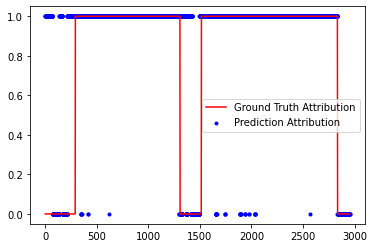

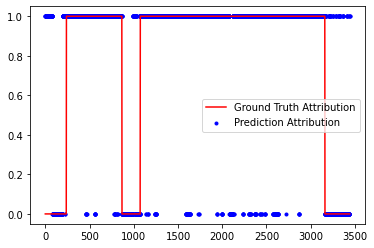

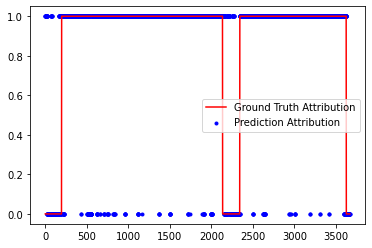

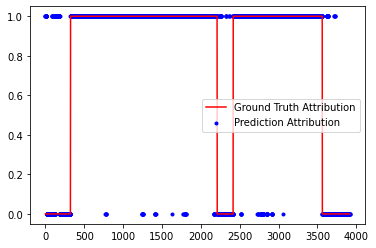

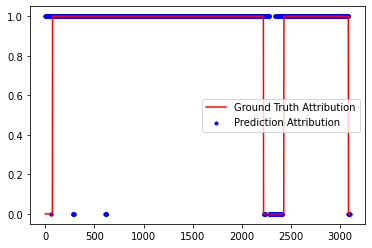

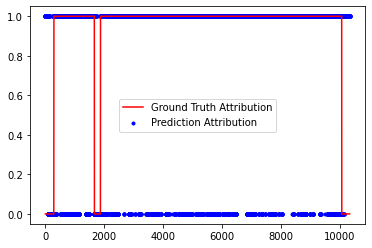

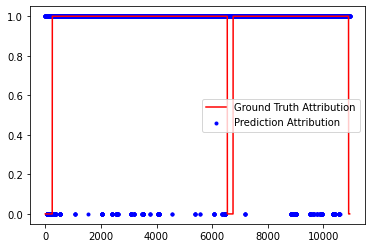

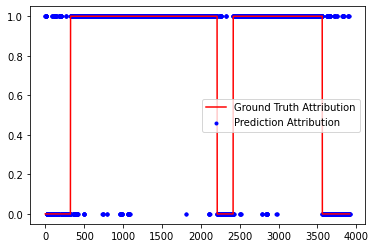

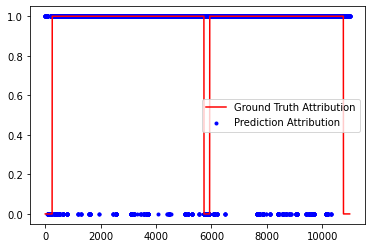

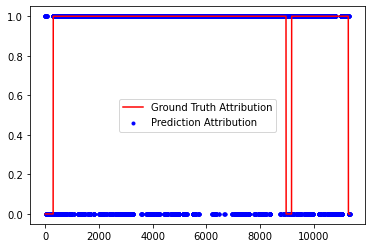

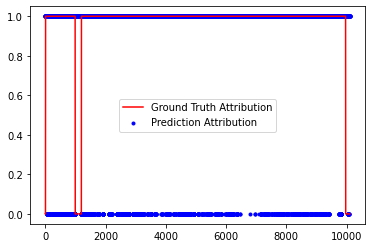

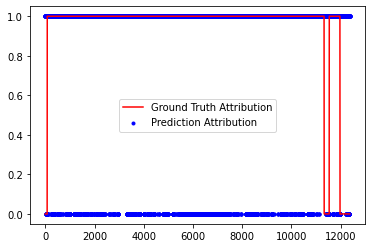

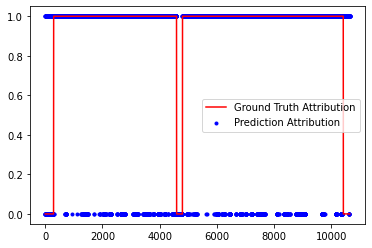

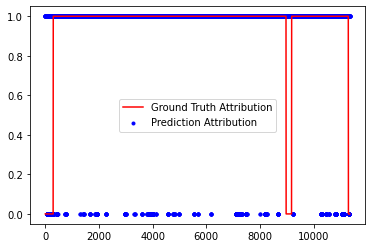

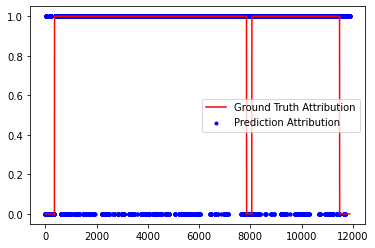

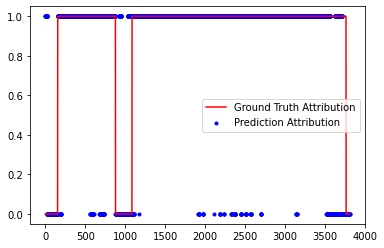

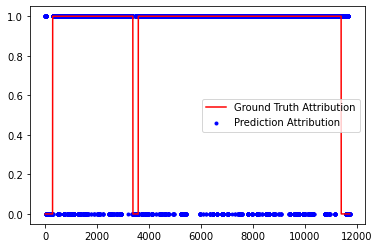

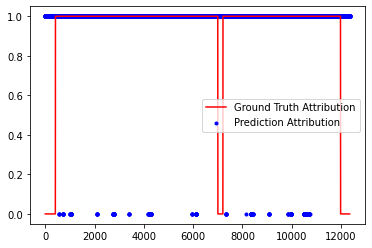

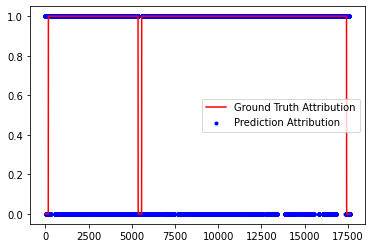

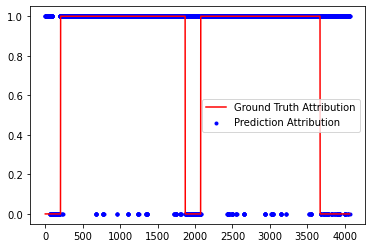

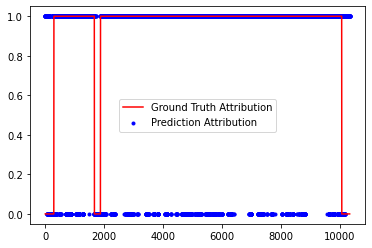

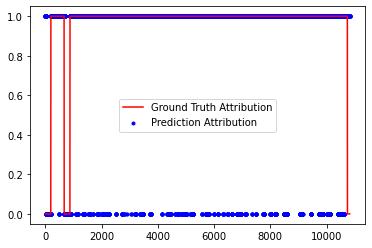

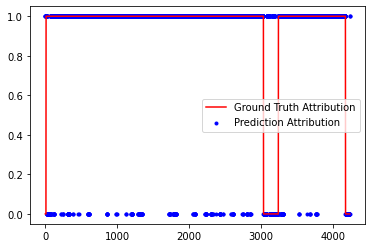

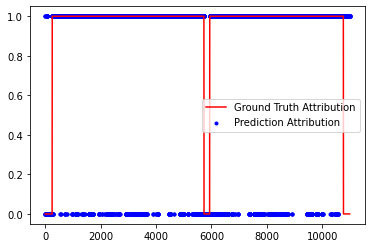

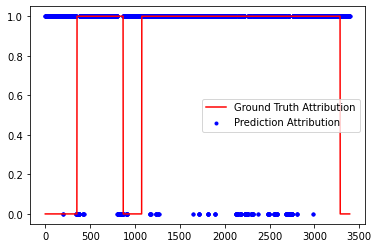

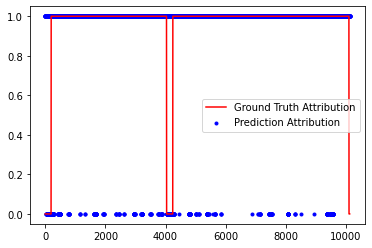

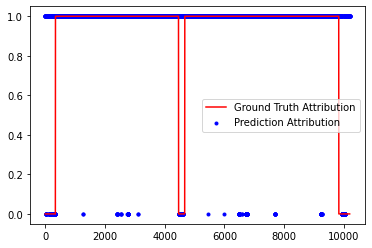

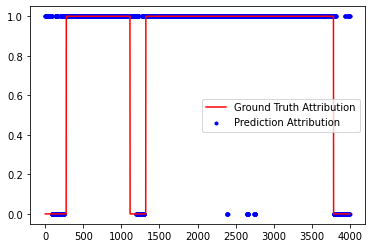

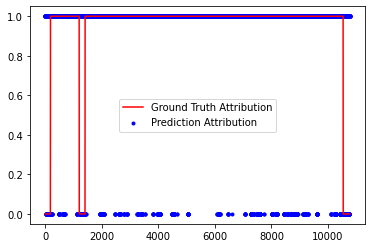

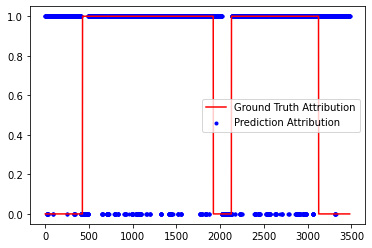

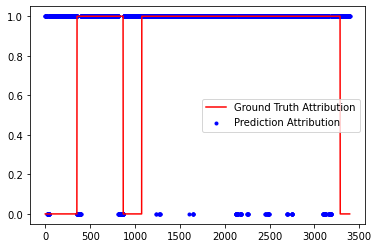

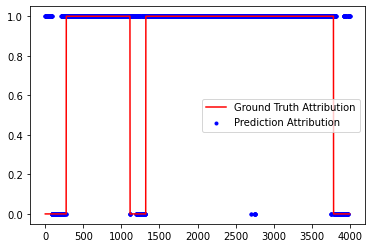

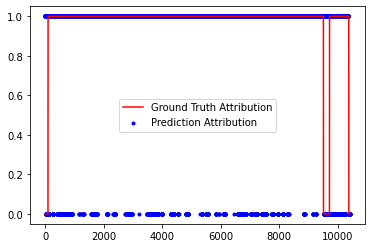

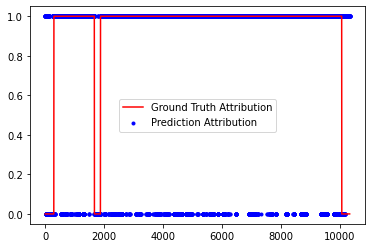

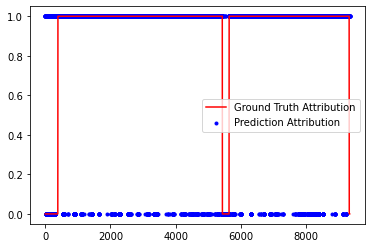

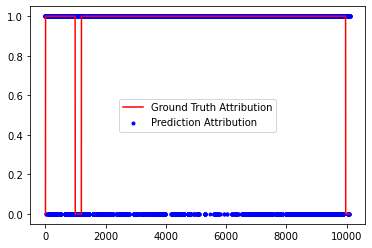

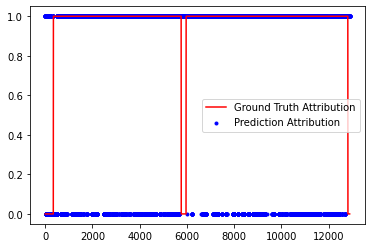

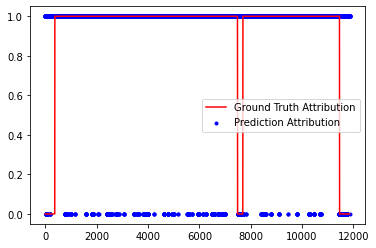

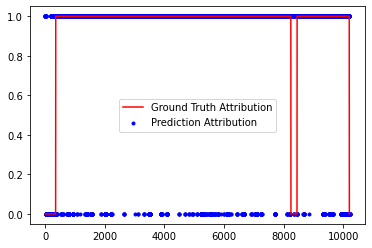

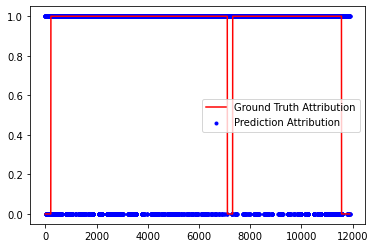

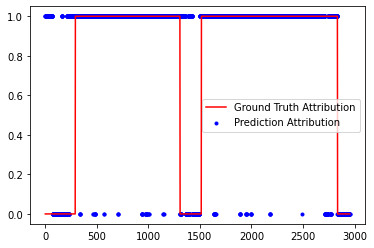

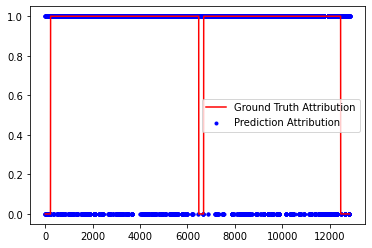

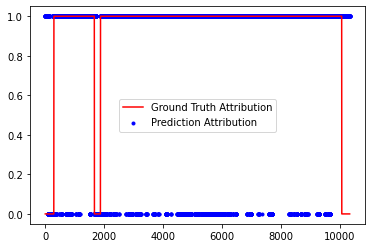

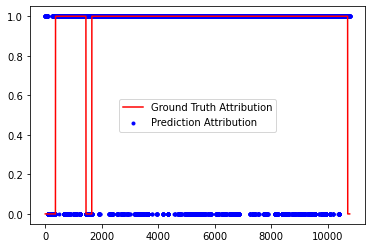

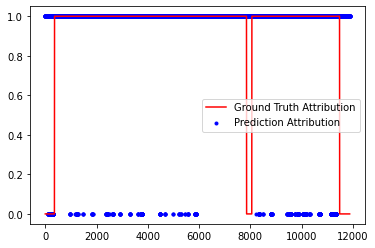

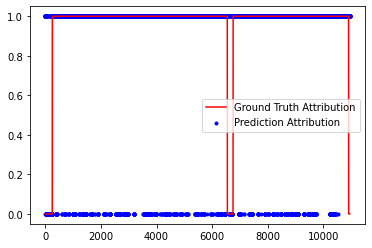

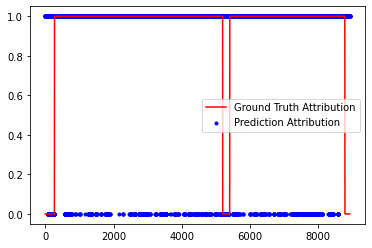

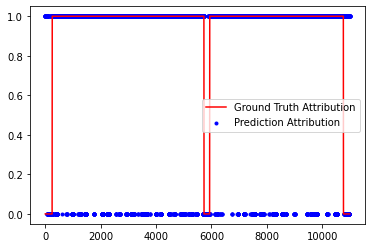

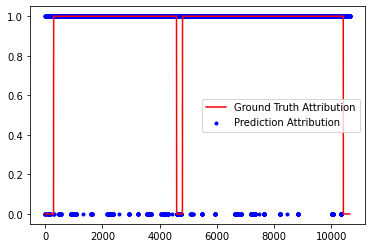

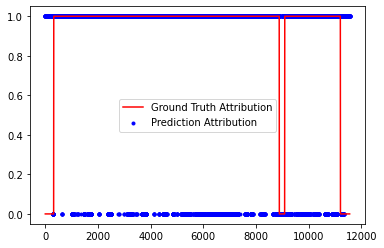

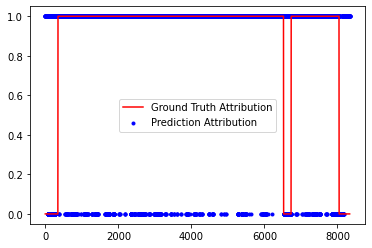

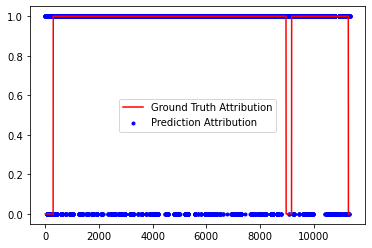

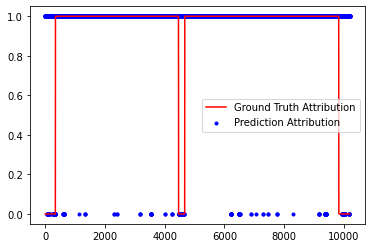

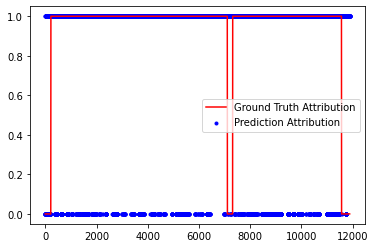

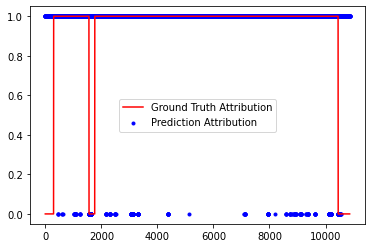

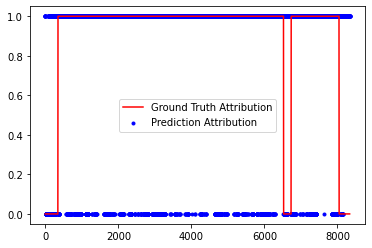

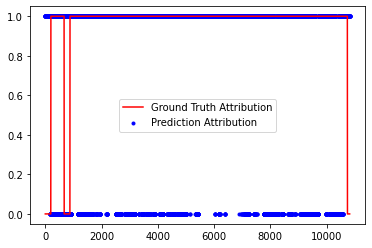

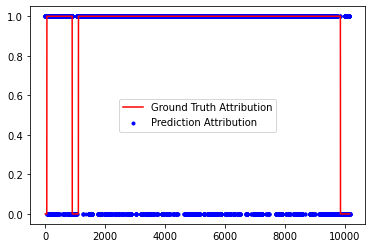

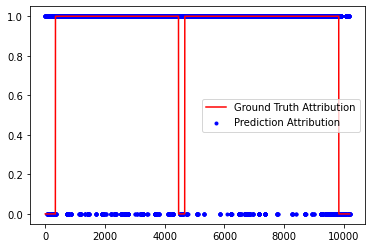

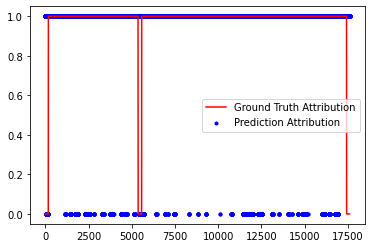

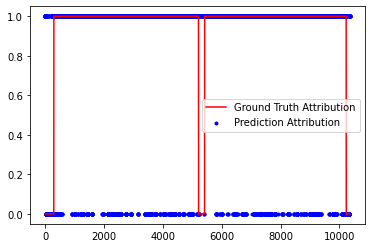

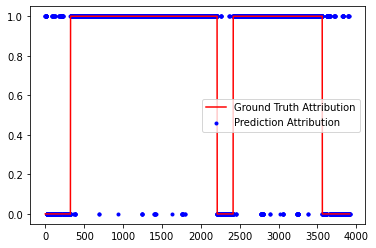

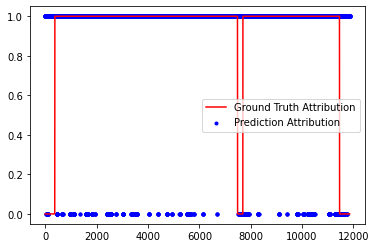

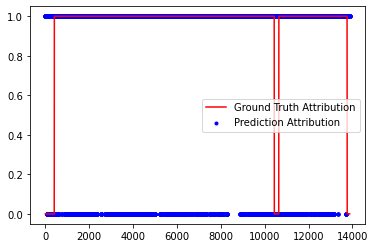

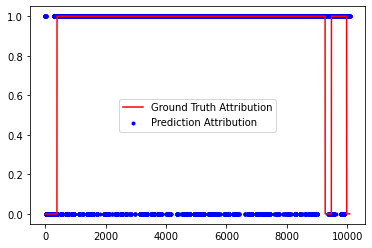

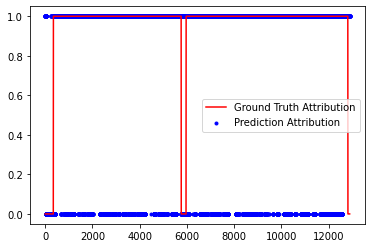

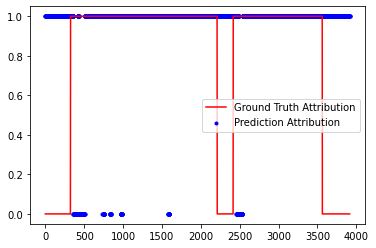

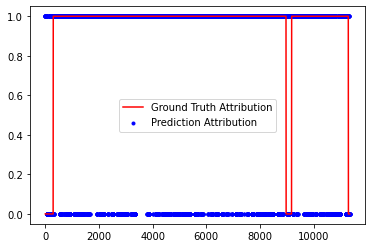

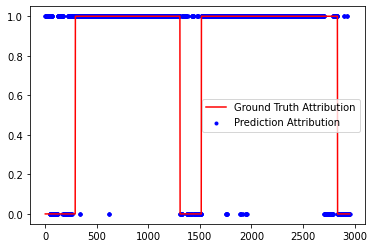

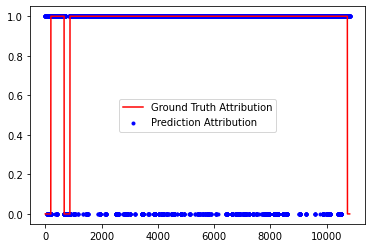

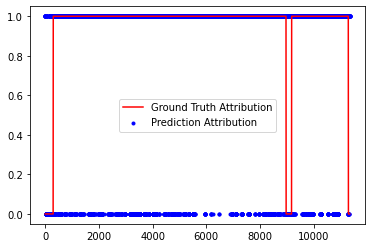

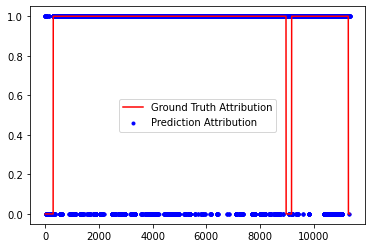

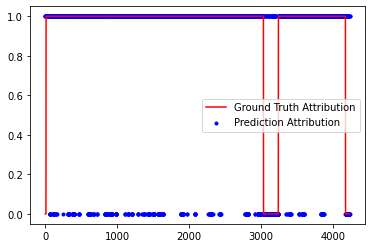

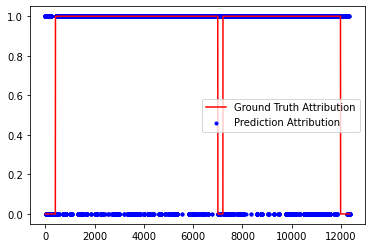

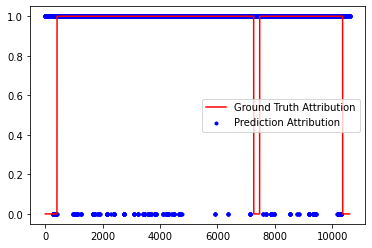

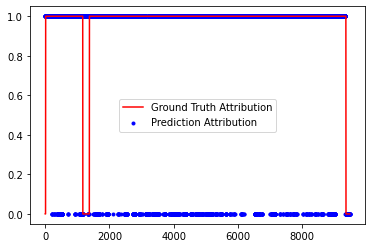

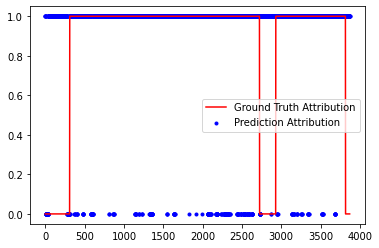

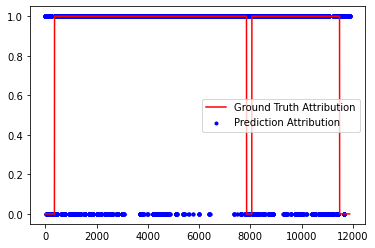

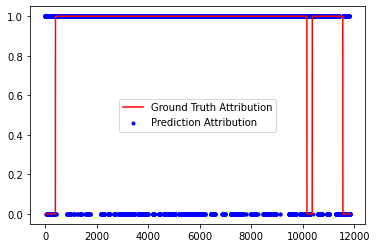

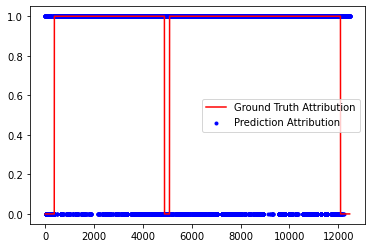

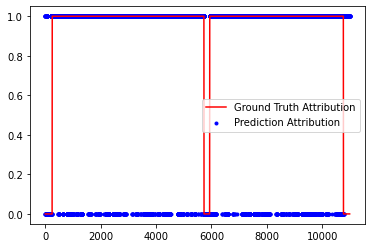

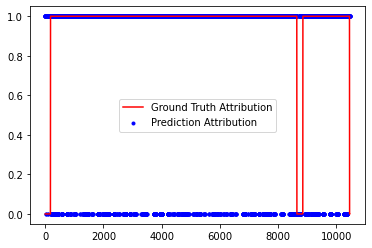

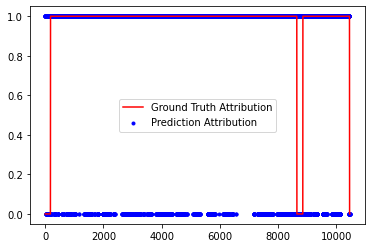

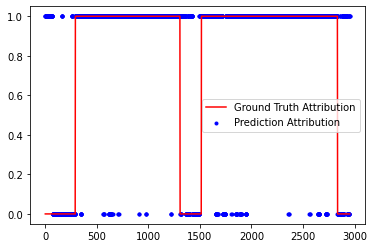

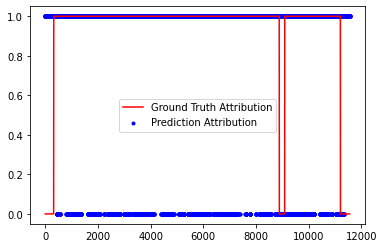

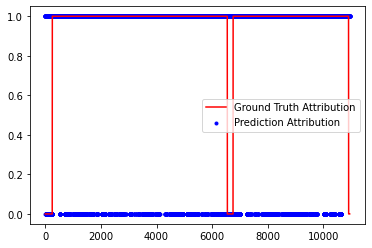

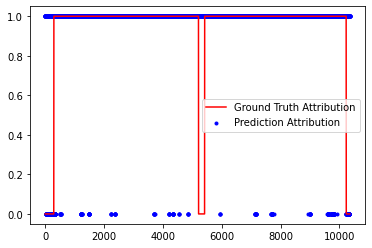

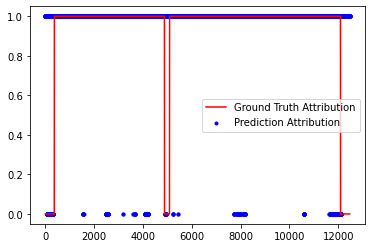

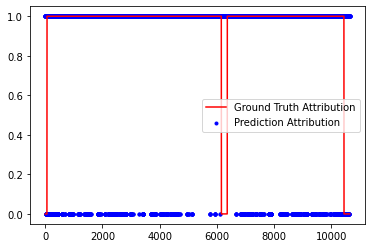

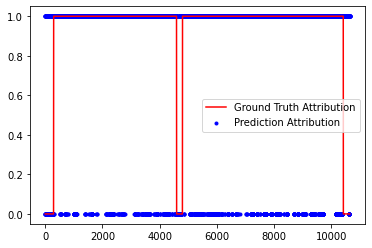

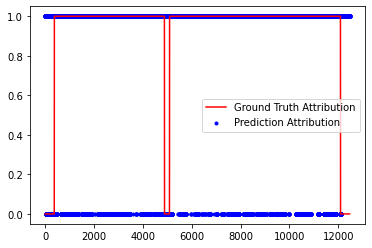

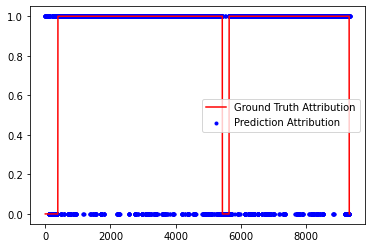

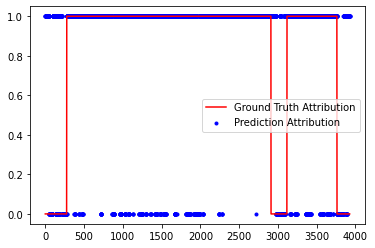

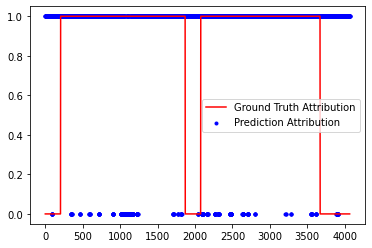

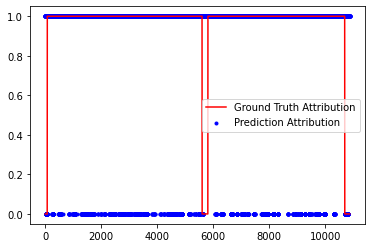

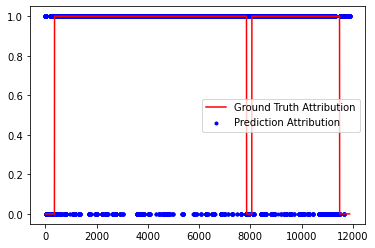

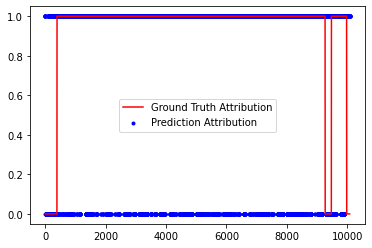

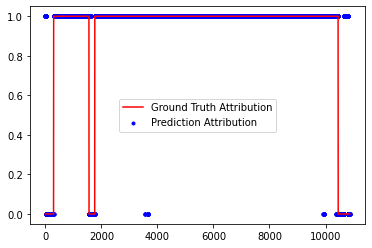

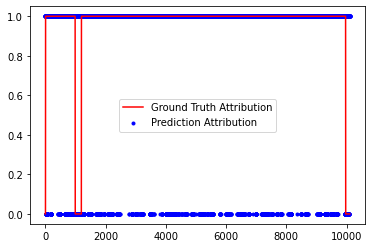

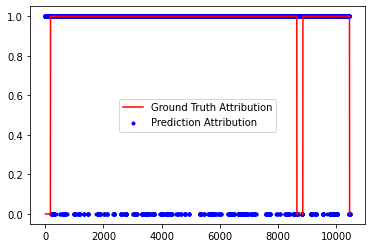

In [53]:
for i in range(100):
    plt.figure()
    plt.plot(allAttrib[i][:,0]==0, color='red', label='Ground Truth Attribution');
    plt.scatter(np.arange(allAttrib[i].shape[0]), allAttrib[i][:,1], marker='.', color='blue', label='Prediction Attribution');
    plt.legend()
    plt.show()

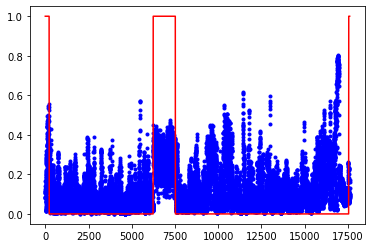

In [45]:
# index 1
plt.plot(attrib[:,0], color='red')
plt.scatter(np.arange(attrib.shape[0]), attrib[:,1], marker='.', color='blue')

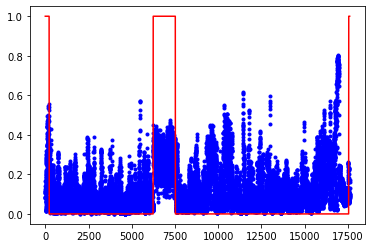

In [48]:
# index 2
plt.plot(attrib[:,0], color='red')
plt.scatter(np.arange(attrib.shape[0]), attrib[:,1], marker='.', color='blue')